## Compare Step-Index computations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from scipy.io import savemat

import gc
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

from mmfsim.phase import LinearPhase
from mmfsim.grid import Grid
from mmfsim.fiber import StepIndexFiber
from mmfsim.beams import GaussianBeam
from mmfsim.coupling import StepIndexFiberDegenCoupler
from mmfsim.transforms import fourier_transform
from mmfsim.devices import MockDeformableMirror

### Simulation variables

In [2]:
fiber_radius = 25e-6
fiber_length = 1e0
power_n = 7
power_n_fourier = 11
grid_length_fourier = 2 ** power_n_fourier
grid_length = 2 ** power_n
grid_size = 3 * fiber_radius
pixel_size = grid_size / grid_length

fiber_kwargs = dict(radius=fiber_radius, wavelength=1064e-9, n1=1.4665, n2=1.45)
grid_kwargs = dict(pixel_size=pixel_size, pixel_numbers=(grid_length, grid_length))

### Define the fiber

In [3]:
grid = Grid(**grid_kwargs)
fiber = StepIndexFiber(**fiber_kwargs)
print(fiber)

c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:247: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(v**2 - u**2)
c:\users\saucourt\coding\mmf_lp_modes\mmfsim\fiber.py:248: RuntimeWarning: invalid value encountered in divide
  return sp.jv(n, u) / (u * sp.jv(n - 1, u)) + sp.kn(n, w) / (w * sp.kn(n - 1, w))


StepIndexFiber instance with:
  - Radius: 25.0 um
  - Core index: 1.4665
  - Cladding index: 1.45
  - Wavelength: 1064.0 nm
  - Numerical aperture: 0.219
  - Number of guided LP modes: 140
  - Number of guided LP modes (counting degenerates): 269
  - First 10 LP_n,m modes characteristics:
  n_eff      h          n          m
[[ 1.46641487  0.          0.          1.        ]
 [ 1.46628389  2.          1.          1.        ]
 [ 1.46611179  4.          2.          1.        ]
 [ 1.46605151  1.          0.          2.        ]
 [ 1.46590084  6.          3.          1.        ]
 [ 1.46577563  3.          1.          2.        ]
 [ 1.46565244  8.          4.          1.        ]
 [ 1.46545734  5.          2.          2.        ]
 [ 1.46539799  2.          0.          3.        ]
 [ 1.46536754 10.          5.          1.        ]]


In [4]:
fiber.compute_modes_fields(grid)
clear_output(wait=False)

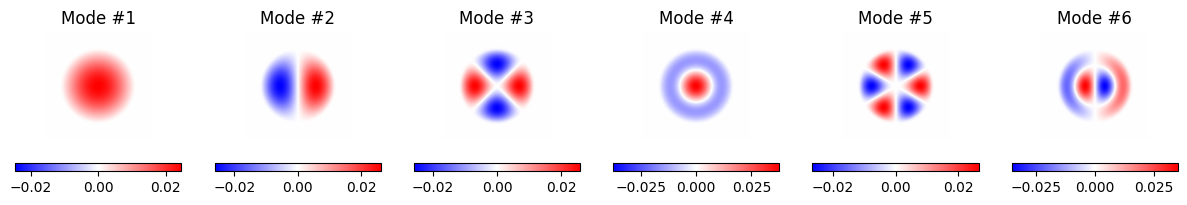

In [5]:
plt.figure(figsize=(15, 2))

max_modes = 6

for i in range(max_modes):
    plt.subplot(1, max_modes, i+1)
    mode = fiber._modes[:, :, 0, i]
    plt.imshow(mode, cmap='bwr', vmin=-np.max(np.abs(mode)), vmax=+np.max(np.abs(mode)))
    plt.axis('off')
    plt.title(f'Mode #{i+1}')
    plt.colorbar(orientation='horizontal')

### Define fitness and helpful functions

In [6]:
from waveoptics.metrics.numpy import quality, pearson

def make_diagonal_mode_coupling_matrix(fiber, fiber_length) -> np.ndarray:
    prop_constants = fiber._prop_constants.copy() # Columns with beta, n_eff, n, m, u, w
    print(prop_constants.shape)

    degen_betas = np.zeros(shape=(fiber._N_modes_degen))
    k = 0
    for i in range(fiber._N_modes):
        if prop_constants[i, 2] == 0: # Mode is centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            k += 1
        else: # Mode is not centro-symmetric
            degen_betas[k] = prop_constants[i, 0]
            degen_betas[k+1] = prop_constants[i, 0]
            k += 2

    propagation_matrix = np.diag(np.exp(-1j * degen_betas * fiber_length))
    return propagation_matrix

def generate_deformed_input_beam(phi) -> np.ndarray:
    # phase = LinearPhase(grid)
    # phase.compute(coeffs=[0.5e-4, 1])

    beam = GaussianBeam(grid)
    beam.compute(amplitude=1, width=fiber.radius/2, centers=[0, 0])
    beam.field = np.complex64(fiber._modes[:, :, 0, 0])
    # beam.add_phase(phase.phase)
    beam.normalize_by_energy()

    n2 = phi.size
    n = int(np.sqrt(phi.size))
    phase_map = phi.reshape(n, n)

    dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2.4*fiber.radius, offsets=(0*fiber.radius, 0))
    dm.apply_phase_map(phase_map)

    beam.field *= dm._field_matrix
    return beam.field


def generate_deformed_cplx_input_beam(x_reim) -> np.ndarray:
    # phase = LinearPhase(grid)
    # phase.compute(coeffs=[0.5e-4, 1])

    beam = GaussianBeam(grid)
    beam.compute(amplitude=1, width=fiber.radius/2, centers=[0, 0])
    beam.field = np.complex64(fiber._modes[:, :, 0, 0])
    # beam.add_phase(phase.phase)
    beam.normalize_by_energy()

    n2 = x_reim.size
    re_map = x_reim[:n2//2]
    im_map = x_reim[n2//2:]
    n = int(np.sqrt(x_reim.size // 2))

    cplx_map = re_map.reshape(n, n) + 1j * im_map.reshape(n, n)

    dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2.4*fiber.radius, offsets=(0*fiber.radius, 0))
    dm.apply_phase_map(np.angle(cplx_map))
    dm.apply_amplitude_map(np.abs(cplx_map))


    beam.field *= dm._field_matrix
    return beam.field


def plot_dm_from_reim(x_reim):
    beam = GaussianBeam(grid)
    beam.compute(amplitude=1, width=fiber.radius/2, centers=[0, 0])
    beam.field = np.complex64(fiber._modes[:, :, 0, 0])
    # beam.add_phase(phase.phase)
    beam.normalize_by_energy()

    n2 = x_reim.size
    re_map = x_reim[:n2//2]
    im_map = x_reim[n2//2:]
    n = int(np.sqrt(x_reim.size // 2))

    cplx_map = re_map.reshape(n, n) + 1j * im_map.reshape(n, n)

    dm = MockDeformableMirror(pixel_size=grid.pixel_size, pixel_numbers=grid.pixel_numbers, diameter=2*fiber.radius, offsets=(0*fiber.radius, 0))
    dm.apply_phase_map(np.angle(cplx_map))
    dm.apply_amplitude_map(np.abs(cplx_map))
    dm.plot()


def couple_input_beam(field):
    coupled_in = StepIndexFiberDegenCoupler(field, grid, fiber, N_modes=fiber._N_modes_degen)
    return coupled_in


def propagate(coupled_in, propagation_matrix) -> np.ndarray:
    new_coeffs = propagation_matrix @ coupled_in.modes_coeffs

    coupled_out = deepcopy(coupled_in)
    coupled_out.modes_coeffs = new_coeffs
    coupled_out.recompose()

    return coupled_out


def get_output_field_from_reim(reim, propagation_matrix):
    field = generate_deformed_cplx_input_beam(reim)
    coupled_in = couple_input_beam(field)
    coupled_out = propagate(coupled_in, propagation_matrix)
    return coupled_out


def fitness_function_from_reim(reim, target_field, propagation_matrix):
    coupled_out = get_output_field_from_reim(reim, propagation_matrix)
    # loss = -quality(coupled_out.field / np.max(np.abs(coupled_out.field)), target_field / np.max(np.abs(target_field)), squared=True)
    # loss = -pearson(np.square(np.abs(coupled_out.field)), np.square(np.abs(target_field)))
    loss = -np.square(np.abs(coupled_out.modes_coeffs[2]))
    return loss



def get_output_field_from_phases(phi, propagation_matrix):
    field = generate_deformed_input_beam(phi)
    coupled_in = couple_input_beam(field)
    coupled_out = propagate(coupled_in, propagation_matrix)
    return coupled_out


def fitness_function_from_phases(phi, target_field, propagation_matrix):
    coupled_out = get_output_field_from_phases(phi, propagation_matrix)
    # loss = -quality(coupled_out.field, target_field, squared=True)
    # loss = -pearson(np.square(np.abs(coupled_out.field)), np.square(np.abs(target_field)))
    loss = -np.square(np.abs(coupled_out.modes_coeffs[0]))
    return loss


### Optimize using CMA-ES from Nevergrad

(140, 6)


(<Figure size 1500x500 with 2 Axes>, <Axes: >)

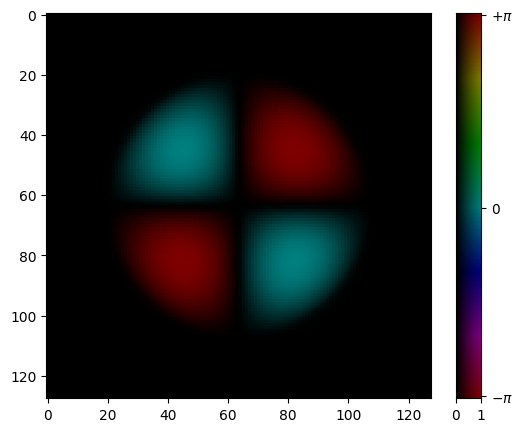

In [7]:
from waveoptics.plots.plots import complex_imshow
from scipy.ndimage import gaussian_filter

propagation_matrix = make_diagonal_mode_coupling_matrix(fiber, fiber_length)
target_field = np.complex64(fiber._modes[:, :, 1, 2])

# target_field = np.zeros_like(target_field)
# target_field[target_field.shape[0] // 2, target_field.shape[1] // 2] = 1
# target_field = gaussian_filter(target_field, sigma=3)


complex_imshow(target_field)

In [ ]:
import nevergrad as ng
from nevergrad.optimization import optimizerlib

COMPLEX = True

def fitness_func(solution):
    return fitness_function_from_phases(solution, target_field, propagation_matrix)

def fitness_func_cplx(solution):
    return fitness_function_from_reim(solution, target_field, propagation_matrix)


n = 16
if COMPLEX:
    # x0 = 1 / np.sqrt(2) * np.random.rand(2*n**2)
    x0 = np.ones(shape=(n**2)) * np.exp(1j * 2 * np.pi * np.random.rand(n**2))
    x0 = np.concatenate([np.real(x0), np.imag(x0)])
    ub = 1.0
    lb = -1.0
    obj_func = fitness_func_cplx
else:
    x0 = 2 * np.pi * np.random.rand(n**2) - np.pi
    ub = +np.pi
    lb = -np.pi
    obj_func = fitness_func



# Define the search space
param = ng.p.Array(
    init=x0,
    # shape=(phi0.size,),
    lower=lb,
    upper=ub,
)
# param.set_standard_deviation(1.0)

# optimizer = ng.optimizers.CMA(
#     parametrization=param,
#     budget=100,
#     num_workers=1,
# )


# Manual optimization loop with custom popsize
popsize = 10
generations = 50

optimizer = ng.optimizers.NgIohTuned(
    parametrization=param,
    budget=popsize * generations,
    num_workers=50,
)

for gen in range(generations):  # 50 generations × 20 = 1000 total evals
    candidates = [optimizer.ask() for _ in range(popsize)]

    values = []
    for indiv, candidate in enumerate(candidates):
        value = obj_func(candidate.value)
        optimizer.tell(candidate, value)
        values.append(value)

    print(f"Gen #{gen}:\n\tAverage = {np.mean(values)}\n\tBest = {np.min(values)}")


# # Run the optimization
# recommendation = optimizer.minimize(
#     objective_function=obj_func,
#     verbosity=1,
# )


# Best result after all iterations
recommendation = optimizer.provide_recommendation()
print("\nBest solution:", recommendation.value)
print("Best fitness :", obj_func(recommendation.value))

Gen #0:
	Average = -0.0017691199638987729
	Best = -0.0023441945170968458


KeyboardInterrupt: 

In [8]:
import nevergrad as ng

from nevergrad.optimization import optimizerlib
from concurrent import futures

COMPLEX = True

def fitness_func(solution):
    return fitness_function_from_phases(solution, target_field, propagation_matrix)

def fitness_func_cplx(solution):
    return fitness_function_from_reim(solution, target_field, propagation_matrix)


n = 16
if COMPLEX:
    # x0 = 1 / np.sqrt(2) * np.random.rand(2*n**2)
    x0 = np.ones(shape=(n**2)) * np.exp(1j * 2 * np.pi * np.random.rand(n**2))
    x0 = np.concatenate([np.real(x0), np.imag(x0)])
    ub = 1.0
    lb = -1.0
    obj_func = fitness_func_cplx
else:
    x0 = 2 * np.pi * np.random.rand(n**2) - np.pi
    ub = +np.pi
    lb = -np.pi
    obj_func = fitness_func



# Define the search space
param = ng.p.Array(
    init=x0,
    # shape=(phi0.size,),
    lower=lb,
    upper=ub,
)
# param.set_standard_deviation(1.0)

# optimizer = ng.optimizers.CMA(
#     parametrization=param,
#     budget=100,
#     num_workers=1,
# )


# Manual optimization loop with custom popsize
popsize = 10
generations = 50

optimizer = ng.optimizers.NgIohTuned(
    parametrization=param,
    budget=popsize * generations,
    num_workers=50,
)

for gen in range(generations):  # 50 generations × 20 = 1000 total evals
    candidates = [optimizer.ask() for _ in range(popsize)]

    values = []
    for indiv, candidate in enumerate(candidates):
        value = obj_func(candidate.value)
        optimizer.tell(candidate, value)
        values.append(value)

    print(f"Gen #{gen}:\n\tAverage = {np.mean(values)}\n\tBest = {np.min(values)}")


# # Run the optimization
# recommendation = optimizer.minimize(
#     objective_function=obj_func,
#     verbosity=1,
# )


# Best result after all iterations
recommendation = optimizer.provide_recommendation()
print("\nBest solution:", recommendation.value)
print("Best fitness :", obj_func(recommendation.value))

Gen #0:
	Average = -0.0011921645360888507
	Best = -0.0018504475886305107
Gen #1:
	Average = -0.0009698362763714028
	Best = -0.0018581684741396927


KeyboardInterrupt: 

In [57]:
# Best result after all iterations
recommendation = optimizer.provide_recommendation()
print("\nBest solution:", recommendation.value)
print("Best fitness :", obj_func(recommendation.value))


Best solution: [-0.02916895  0.91509736  0.09998465  0.03169211  0.83914061  0.76257574
  0.66889181  0.41822548  0.83660281 -0.96026829 -0.53984888 -0.93099417
 -0.36915399 -0.91724613 -0.3562843  -0.05773294  0.93484067 -0.41550021
 -0.73221632  0.89910492 -0.49291137 -0.37191502 -0.6010637   0.84664837
  0.28884626  0.40484073  0.63035943  0.20280804 -0.8836052  -0.55672645
  0.93903704  0.43665896]
Best fitness : -0.5548750886736267


Pearson intensity: 0.6447966075448269
Quality squared: 0.017357870302390013


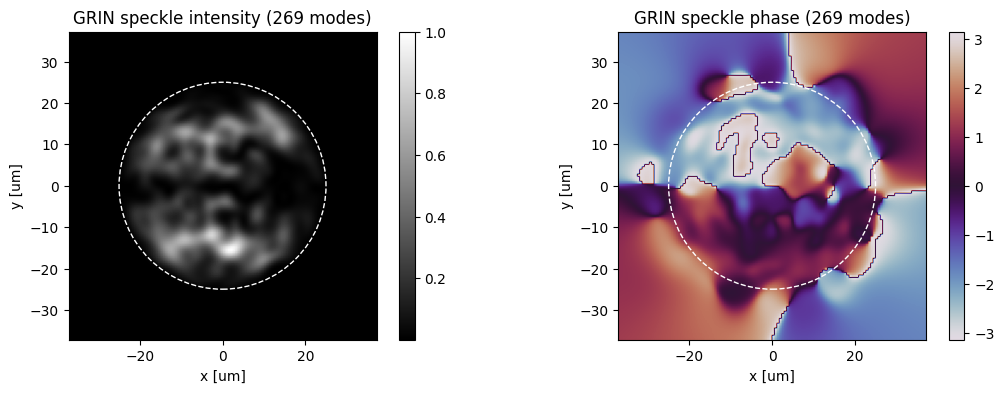

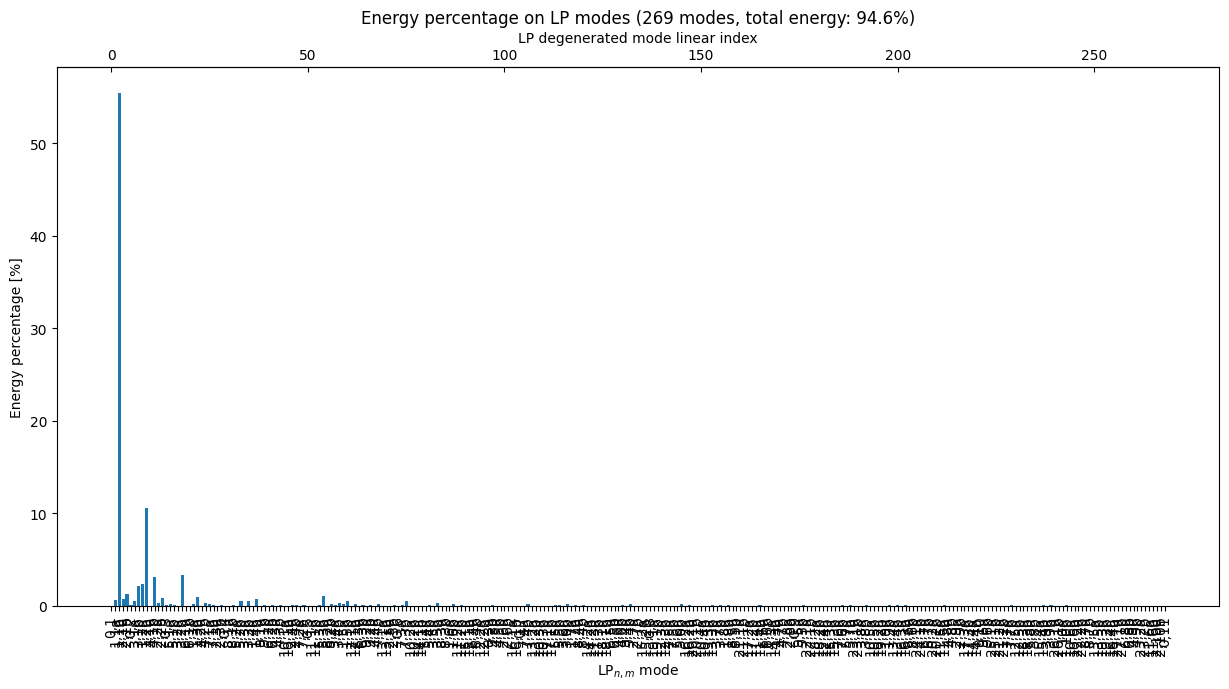

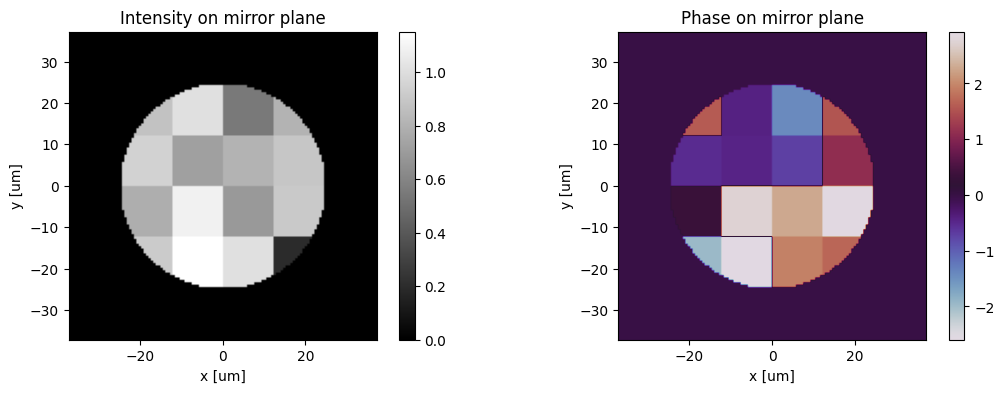

In [58]:
if COMPLEX:
    best_coupled_out = get_output_field_from_reim(recommendation.value, propagation_matrix)
else:
    best_coupled_out = get_output_field_from_phases(recommendation.value, propagation_matrix)

pear = pearson(np.square(np.abs(best_coupled_out.field)), np.square(np.abs(target_field)))
qual = quality(best_coupled_out.field, target_field, squared=True)
print(f"Pearson intensity: {pear}")
print(f"Quality squared: {qual}")

# best_coupled_out = get_output_field_from_phases(phi0.flatten(), propagation_matrix)
best_coupled_out.plot(complex=True, complex_hsv=False)
best_coupled_out.plot_coefficients()

plot_dm_from_reim(recommendation.value)

In [29]:
import cma
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=1/3,
    options={
        'bounds': [-1, 1],
        # 'popsize': 20,
    },
)

es.optimize(fitness_func_cplx, iterations=50)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

# plt.imshow(np.square(get_amplitude_from_phases(best_solution, TM, m)))

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 128 (seed=152020, Wed Apr 30 12:48:15 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 -2.717753200065427e-02 1.0e+00 3.23e-01  3e-01  3e-01 0:03.7
    2     36 -5.007867639363361e-02 1.0e+00 3.14e-01  3e-01  3e-01 0:07.5
    3     54 -6.086599649756709e-02 1.0e+00 3.07e-01  3e-01  3e-01 0:11.3
    4     72 -7.094626341481902e-02 1.0e+00 3.02e-01  3e-01  3e-01 0:15.1
    6    108 -1.847435558207674e-01 1.0e+00 2.96e-01  3e-01  3e-01 0:22.6
    8    144 -2.311682492642547e-01 1.0e+00 2.93e-01  3e-01  3e-01 0:30.1
   10    180 -3.360609668614706e-01 1.0e+00 2.93e-01  3e-01  3e-01 0:37.8
   12    216 -3.807473453137301e-01 1.0e+00 2.95e-01  3e-01  3e-01 0:45.4
   15    270 -4.433993622952145e-01 1.1e+00 2.98e-01  3e-01  3e-01 0:56.7
   18    324 -4.982998875170674e-01 1.1e+00 3.00e-01  3e-01  3e-01 1:08.2
   21    378 -5.734522095816929e-01 1.1e+00 3.04e-01  3e-01  3e-01 1:19.7
   24    432 -5.83912

In [31]:
es = cma.CMAEvolutionStrategy(
    x0=best_solution,
    sigma0=1/3,
    options={
        'bounds': [-1, 1],
        # 'popsize': 20,
    },
)

es.optimize(fitness_func_cplx, iterations=50)
# Get best solution and show it
best_solution = es.result.xbest 
best_value = es.result.fbest
best_eval = es.result.evals_best
fevals = es.result.evaluations

print(f"fevals={fevals}, best_value={best_value}, best_eval={best_eval}")

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 128 (seed=112019, Wed Apr 30 12:51:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 -6.654422501525585e-01 1.0e+00 3.21e-01  3e-01  3e-01 0:03.8
    2     36 -6.637365340289927e-01 1.0e+00 3.12e-01  3e-01  3e-01 0:07.6
    3     54 -6.737137325707252e-01 1.0e+00 3.05e-01  3e-01  3e-01 0:11.4
    4     72 -6.933187470829265e-01 1.0e+00 2.99e-01  3e-01  3e-01 0:15.2
    6    108 -7.331399652817155e-01 1.0e+00 2.87e-01  3e-01  3e-01 0:22.9
    8    144 -7.440812221494220e-01 1.0e+00 2.77e-01  3e-01  3e-01 0:30.6
   10    180 -8.014321422272417e-01 1.0e+00 2.68e-01  3e-01  3e-01 0:38.2
   12    216 -7.712976955640727e-01 1.0e+00 2.62e-01  3e-01  3e-01 0:45.7
   15    270 -7.967239448377406e-01 1.0e+00 2.53e-01  3e-01  3e-01 0:57.0
   18    324 -7.748014261268740e-01 1.0e+00 2.46e-01  2e-01  2e-01 1:08.4
   21    378 -7.926378281090436e-01 1.1e+00 2.38e-01  2e-01  2e-01 1:19.8
   24    432 -8.09551

Pearson intensity: 0.6341742397687296
Quality squared: 0.00510263203861503


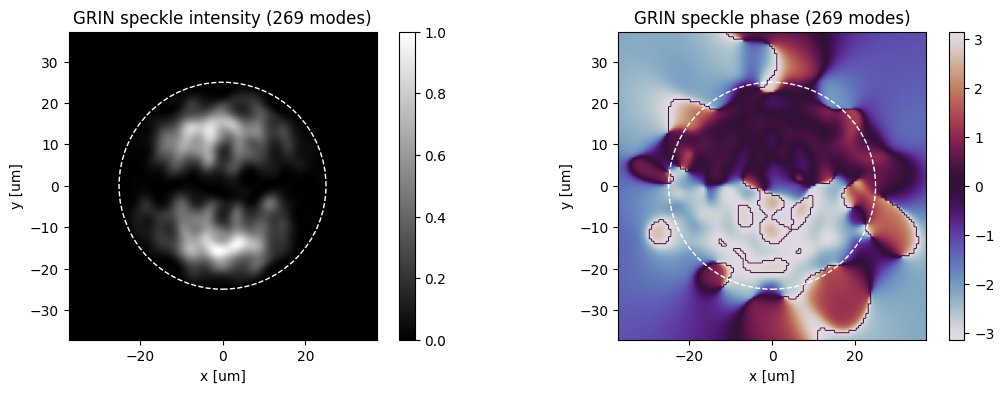

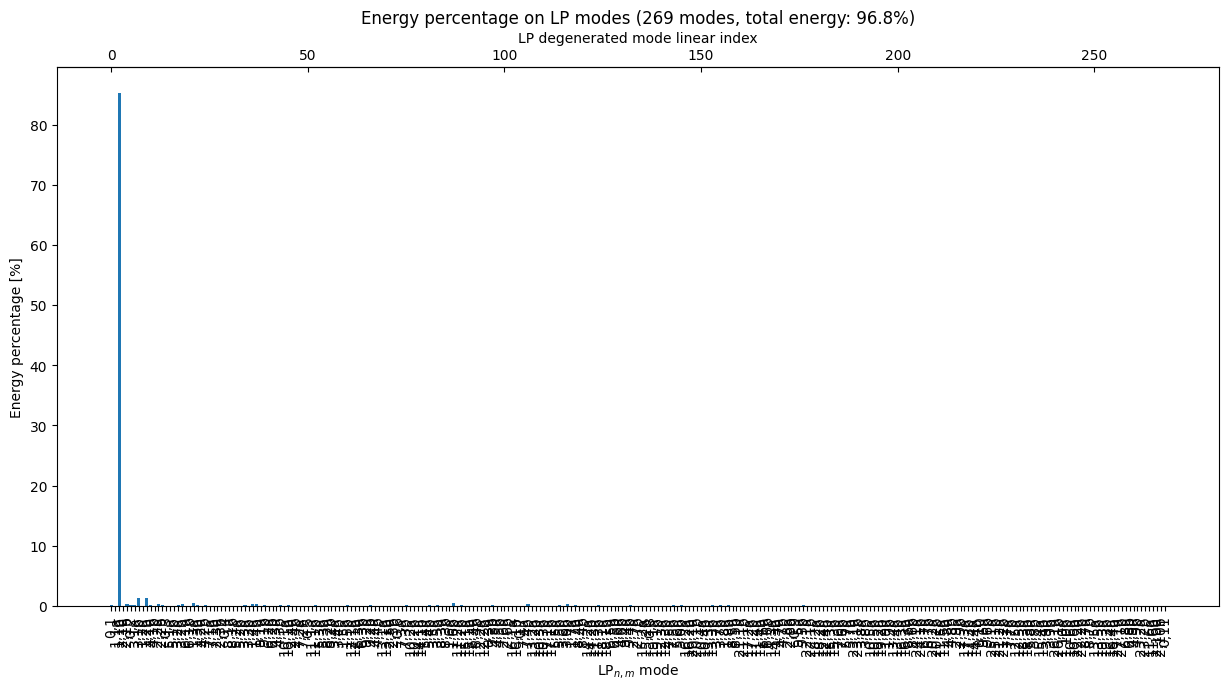

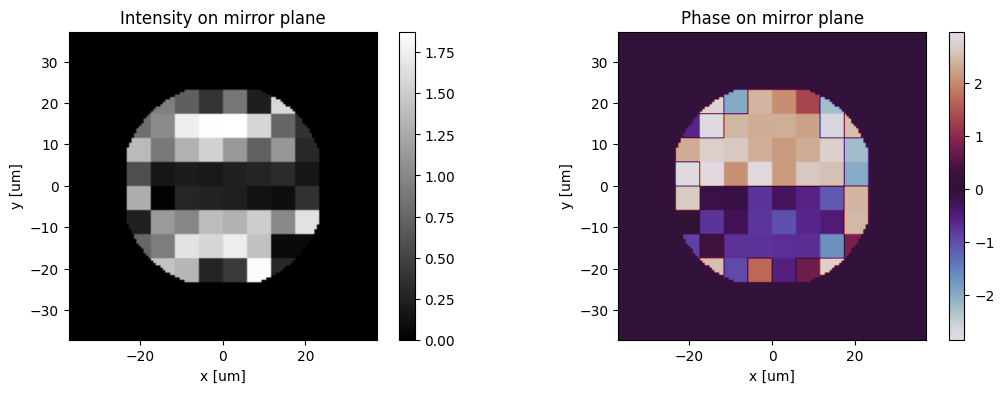

In [32]:
if COMPLEX:
    best_coupled_out = get_output_field_from_reim(best_solution, propagation_matrix)
else:
    best_coupled_out = get_output_field_from_phases(best_solution, propagation_matrix)

pear = pearson(np.square(np.abs(best_coupled_out.field)), np.square(np.abs(target_field)))
qual = quality(best_coupled_out.field, target_field, squared=True)
print(f"Pearson intensity: {pear}")
print(f"Quality squared: {qual}")

# best_coupled_out = get_output_field_from_phases(phi0.flatten(), propagation_matrix)
best_coupled_out.plot(complex=True, complex_hsv=False)
best_coupled_out.plot_coefficients()

plot_dm_from_reim(best_solution)

Now let's create the propagation matrix with no mode energy exchange, this matrix is diagonal.
Then compute the new modes coefficients. Only their phases should have changed.

### Fourier transform the output speckle after padding it

(2048, 2048)
(2048, 2048)


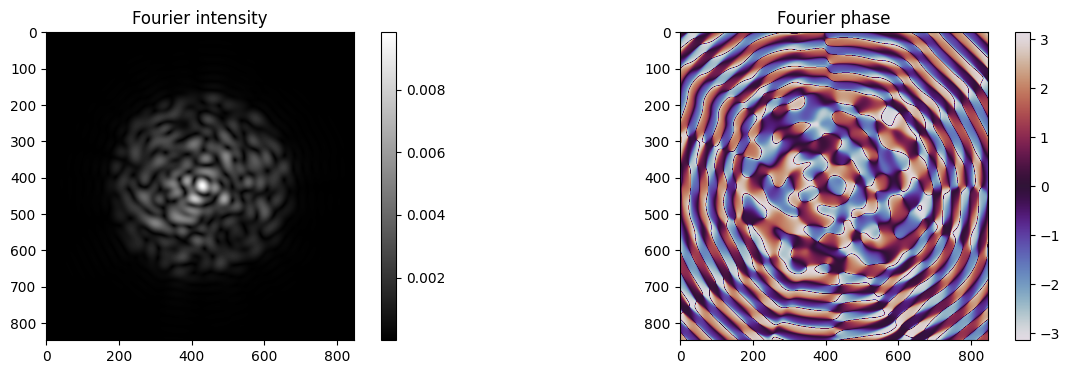

In [506]:
speckle = best_coupled_out.field
pad_amount = (grid_length_fourier - grid_length) // 2
padded_speckle = np.pad(speckle, pad_width=pad_amount)
print(padded_speckle.shape)

speckle_fourier = fourier_transform(padded_speckle)
print(speckle_fourier.shape)

win = slice(600, -600)

fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs[0].set_title('Fourier intensity')
pl0 = axs[0].imshow(np.abs(speckle_fourier[win, win]), cmap='gray')
plt.colorbar(pl0, ax=axs[0])

axs[1].set_title('Fourier phase')
pl1 = axs[1].imshow(np.angle(speckle_fourier[win, win]), cmap='twilight')
plt.colorbar(pl1, ax=axs[1])

### Export for Matlab